<a href="https://colab.research.google.com/github/leonbenenati/Webapp_streamlit/blob/main/Modelo_classifica%C3%A7ao_webapp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## O Dataset possui o custo de um plano de saúde, cada indivíduo na base possui os dados de: Idade, sexo, IMC, filhos, se a pesosa fumante e a região que a pessoa mora

 ## O objetivo é prever se a pessoa fuma ou não, para prever possíveis fraudes

# Ajustes iniciais

In [1]:
#importando bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
#Carrendo os arquivos 
df = pd.read_csv("/content/seguro.csv")

In [3]:
df.head()

,Idade,Sexo,IMC,Filhos,Fumante,Regiao,Custos
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.shape

(1338, 7)

In [5]:
df.isnull().sum()

Idade      0
Sexo       0
IMC        0
Filhos     0
Fumante    0
Regiao     0
Custos     0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Idade    1338 non-null   int64  
 1   Sexo     1338 non-null   object 
 2   IMC      1338 non-null   float64
 3   Filhos   1338 non-null   int64  
 4   Fumante  1338 non-null   object 
 5   Regiao   1338 non-null   object 
 6   Custos   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# Análise das variaveis 

In [7]:
import seaborn as sns

In [9]:
df['Idade'].describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: Idade, dtype: float64

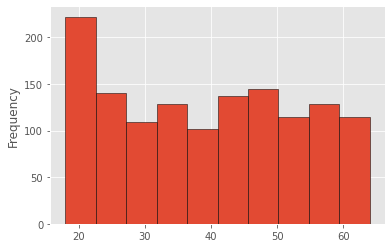

In [8]:
df['Idade'].plot(kind = 'hist',edgecolor = 'black');

*   A média da váriavel idade é 39 anos
*   Idade minima 18 anos e a maxima é 64
*   As idades de 20 a 30 são as mais representativa na base





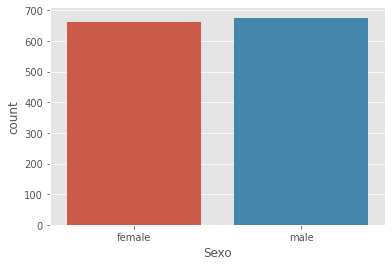

In [ ]:
sns.countplot(x=df["Sexo"])





*   Sexo masculino e feminino está praticamente 50/50





In [10]:
df["IMC"].describe()

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
25%        26.296250
50%        30.400000
75%        34.693750
max        53.130000
Name: IMC, dtype: float64

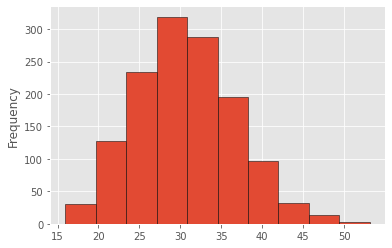

In [11]:
df['IMC'].plot(kind = 'hist',edgecolor = 'black');



*   A média do IMC é 30,66
*   Mínimo é 15,96. Máximo 53,13





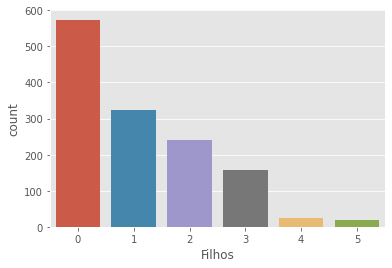

In [ ]:
sns.countplot(x=df["Filhos"])





*   Maioria tem de 0 a 3 filhos




In [14]:
df["Fumante"].value_counts(normalize=True)

no     0.795217
yes    0.204783
Name: Fumante, dtype: float64

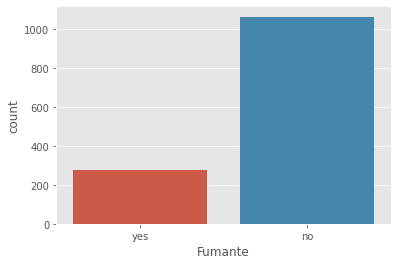

In [ ]:
sns.countplot(x=df["Fumante"])



*   79,52% não fuma



In [16]:
df["Regiao"].value_counts(normalize=True)

southeast    0.272048
southwest    0.242900
northwest    0.242900
northeast    0.242152
Name: Regiao, dtype: float64

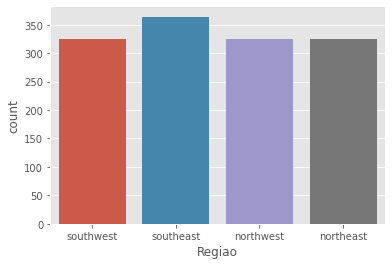

In [ ]:
sns.countplot(x=df["Regiao"])



*   A região southeast tem 27,20%, as outras tem em torno de 24%



In [18]:
df["Custos"].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: Custos, dtype: float64

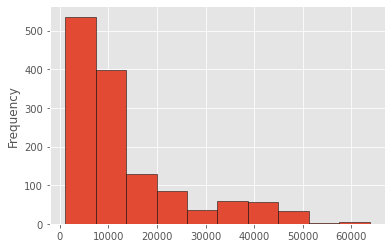

In [ ]:
df['Custos'].plot(kind = 'hist',edgecolor = 'black');



*   Média dos custos é 13270,42


*   Mínimo é 4740,28. Máximo é 63770,42





# Preparação das variáveis 

In [ ]:
#Função para somar a quantidade de filhos 4 e 5 filhos, em 3 filhos
def auxiliar(x):
    if x == 0:
        return 0
    elif x ==1:
        return 1
    elif x ==2:
        return 2
    else:
        return 3
df['Filhos'] = df['Filhos'].apply(auxiliar)

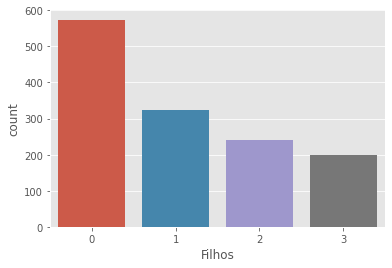

In [ ]:
sns.countplot(x=df["Filhos"])

 

*   4 e 5 filhos foram somadas para 3 filhos


*   A váriavel 3 representa 3 ou mais filhos





In [ ]:
#Criando as váriaveis Dummy onde se faz necessário
variaveis = ["Sexo", "Fumante","Regiao"]

df = pd.get_dummies(df, columns = variaveis, drop_first = True)

df.head()

,Idade,IMC,Filhos,Custos,Sexo_male,Fumante_yes,Regiao_northwest,Regiao_southeast,Regiao_southwest
0,19,27.90,0,16884.92,0,1,0,0,1
1,18,33.77,1,1725.55,1,0,0,1,0
2,28,33.00,3,4449.46,1,0,0,1,0
3,33,22.70,0,21984.47,1,0,1,0,0
4,32,28.88,0,3866.86,1,0,1,0,0


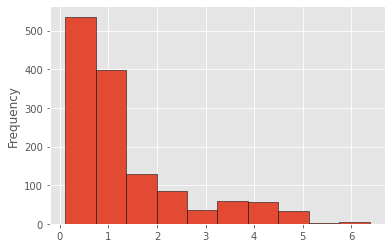

In [ ]:
#Dividindo por 10000 a varáivel custos para ficar em uma escala menor.
df['Custos'] = df['Custos']/10000
df['Custos'].plot(kind = 'hist',edgecolor = 'black');

# Treino e teste

In [ ]:
#Dividindo X e y

X = df.drop('Fumante_yes', axis = 1)
y = df[['Fumante_yes']]

In [ ]:
X = df[['Idade','IMC',"Filhos","Custos","Sexo_male","Regiao_northwest","Regiao_southeast","Regiao_southwest"]]

In [ ]:
X

,Idade,IMC,Filhos,Custos,Sexo_male,Regiao_northwest,Regiao_southeast,Regiao_southwest
0,19,27.90,0,1.69,0,0,0,1
1,18,33.77,1,0.17,1,0,1,0
2,28,33.00,3,0.44,1,0,1,0
3,33,22.70,0,2.20,1,1,0,0
4,32,28.88,0,0.39,1,1,0,0
...,...,...,...,...,...,...,...,...
1333,50,30.97,3,1.06,1,1,0,0
1334,18,31.92,0,0.22,0,0,0,0
1335,18,36.85,0,0.16,0,0,1,0
1336,21,25.80,0,0.20,0,0,0,1


In [ ]:
y

,Fumante_yes
0,1
1,0
2,0
3,0
4,0
...,...
1333,0
1334,0
1335,0
1336,0


In [ ]:
#A variável alvo tem um desbalanceamento, stratify=y, vai manter essa proporção na váriavel  
X_train, X_test, y_train, y_test  = train_test_split(X,y, test_size=0.25,
                                     random_state=42,stratify=y)

# LazyClassifier

##Lazy Predict é uma biblioteca para rodar vários modelos sem ajuste de hiperparametros

In [ ]:
pip install lazypredict

     |████████████████████████████████| 269 kB 7.4 MB/s 
     |████████████████████████████████| 6.8 MB 52.3 MB/s 
     |████████████████████████████████| 127.6 MB 21 kB/s 
     |████████████████████████████████| 248 kB 60.7 MB/s 
     |████████████████████████████████| 25.9 MB 84.3 MB/s 
     |████████████████████████████████| 302 kB 63.9 MB/s 
     |████████████████████████████████| 1.2 MB 58.8 MB/s 
     |████████████████████████████████| 14.5 MB 24.8 MB/s 
     |████████████████████████████████| 72 kB 1.0 MB/s 
     |████████████████████████████████| 10.1 MB 26.2 MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44636 sha256=b713f5cd593394dfbdf63a1b1ca5b79ebb737c20c9efc594fa9efabbac3ae0be
  Stored in directory: /root/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built PyYAML
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully 

In [ ]:
from lazypredict.Supervised import LazyClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:01<00:00, 18.47it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SGDClassifier,0.96,0.97,0.97,0.96,0.02
SVC,0.96,0.96,0.96,0.96,0.03
QuadraticDiscriminantAnalysis,0.95,0.95,0.95,0.95,0.02
LinearSVC,0.96,0.95,0.95,0.96,0.05
LogisticRegression,0.96,0.94,0.94,0.96,0.03
BaggingClassifier,0.96,0.94,0.94,0.96,0.05
RandomForestClassifier,0.96,0.94,0.94,0.96,0.21
XGBClassifier,0.96,0.93,0.93,0.96,0.15
CalibratedClassifierCV,0.96,0.93,0.93,0.96,0.06


Foram escolhidos os modelos de RaRandom Forest e Adaboost para otimizar seus hiperparâmetros com base na metríca F1, F1-score foi escolhida por ser a média harmonica entre Precisão e Recall

# Floresta aleatóra

In [ ]:
# Configuração da Validação
kf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10)

In [ ]:
modelo=RandomForestClassifier()
parametros = {'n_estimators' :np.arange(1,1000,2),
              'criterion':['gini', 'entropy'],
              'max_features': ['sqrt', 'auto', 'log2'],
              'max_depth' : np.arange(1,1000,2)
                 }

random= RandomizedSearchCV(modelo, param_distributions = parametros,scoring="f1", cv = kf,
                                n_iter = 10, verbose = 1, n_jobs = -1)
random.fit(X_train,y_train)
random.best_score_
random.best_estimator_

Fitting 100 folds for each of 10 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 15.6min finished


RandomForestClassifier(criterion='entropy', max_depth=844, max_features='log2',
                       n_estimators=880)

In [ ]:
arvore_pred=random.predict(X_test)
f1_random= f1_score(y_test,arvore_pred)
print(f1_random)

0.9064748201438848


# AdaBoostClassifier

In [ ]:
modelo=AdaBoostClassifier(base_estimator=RandomForestClassifier())
parametros = {'n_estimators' :np.arange(1,200,1),
              'learning_rate':np.arange(0.1,1.5,0.1)
                 }

ada= RandomizedSearchCV(modelo, param_distributions = parametros,scoring="f1", cv = kf,
                                n_iter = 10, verbose = 1, n_jobs = -1)
ada.fit(X_train,y_train)
ada.best_score_
ada.best_estimator_

Fitting 100 folds for each of 10 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.0min finished


AdaBoostClassifier(base_estimator=RandomForestClassifier(), n_estimators=194)

In [ ]:
ada_pred=ada.predict(X_test)
ada_random= f1_score(y_test,ada_pred)
print(ada_random)

0.9285714285714286


In [ ]:
model=ada.best_estimator_

O modelo escolhido foi o AdaBoost

In [ ]:
import pickle

In [ ]:
filename = 'modelo_escolhido.pkl'
pickle.dump(model, open(filename, 'wb'))

Modelo escolhido foi o modelo de AdaBoost